In [2]:
#Para usar colab
!unzip data.zip 

Archive:  data.zip
   creating: data/
   creating: data/train/
   creating: data/train/csv/
  inflating: data/train/csv/NER_MeasuredProperty.csv  
  inflating: data/train/csv/NER_Qualifier.csv  
  inflating: data/train/csv/NER_Quantity.csv  
  inflating: data/train/csv/features_train.txt  
   creating: data/train/text/
  inflating: data/train/text/S0006322312001096-1136.txt  
  inflating: data/train/text/S0006322312001096-1177.txt  
  inflating: data/train/text/S0006322312001096-1190.txt  
  inflating: data/train/text/S0006322312001096-1194.txt  
  inflating: data/train/text/S0006322312001096-1197.txt  
  inflating: data/train/text/S0006322312001096-1202.txt  
  inflating: data/train/text/S0006322312001096-1205.txt  
  inflating: data/train/text/S0006322312001096-1221.txt  
  inflating: data/train/text/S0006322312001096-1230.txt  
  inflating: data/train/text/S0006322312001096-1248.txt  
  inflating: data/train/text/S0006322312001096-1253.txt  
  inflating: data/train/text/S00063223120

In [3]:
!pip install fuzzywuzzy

In [13]:
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.0 MB 4.5 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [1]:
#Para usar cuda con spacy
!pip install -U spacy[cuda101]

     |████████████████████████████████| 119.1 MB 23.6 MB/s 


In [1]:
import pandas as pd 
import os
import random
import spacy
from spacy.pipeline import EntityRecognizer
from spacy import displacy
import json 
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
import numpy as np
gpu = spacy.prefer_gpu()#Para usar la gpu a la hora del entrenamiento
print('GPU:', gpu)

GPU: False


In [5]:
#Texto Plano training
def texto_plano(path):
  text=dict()
  for file in os.listdir(path):
      if file.endswith(".txt"):
          f = open(path+file, "r", encoding="utf-8")
          text[file.replace(".txt","")]=f.readline()
  return text

#Cargar tsv
def loadData(path,format):
  data=dict()
  for file in os.listdir(path):
      if file.endswith(format):
        data[file.replace(format,"")]=pd.read_csv(f"{path}/{file}",sep="\t")
  return data

In [6]:
train_text=texto_plano("data/train/text/")
test_text=texto_plano("data/trial/txt/")

In [7]:
data_train=loadData("data/train/tsv/",".tsv")
data_test=loadData("data/trial/tsv/",".tsv")

In [30]:
#Manejo de traslapes entre entidades
def traslape(df):
  for i in range(5):
    columns=["startOffset","endOffset","annotType"]
    df=df.drop_duplicates(subset=columns, keep="first")
    df=df.sort_values("startOffset")#.reset_index()
    #print(df.loc[:,columns])
    indices=list(df.index)
    text=train_text[df.loc[indices[0],"docId"]]
    #print(indices)
    for i in range(len(indices)-1):
      id1=indices[i]
      id2=indices[i+1]
      inicio1, final1 = df.loc[id1,["startOffset","endOffset"]]
      inicio2, final2 = df.loc[id2,["startOffset","endOffset"]]
      indices1=[j for j in range(inicio1,final1+1)]
      indices2=[j for j in range(inicio2,final2+1)]
      intersection= set(indices1).intersection(indices2)
      if len(intersection)>1:
        min_id=id2
        if final1<final2:
          min_id=id1
        df.drop([min_id],inplace=True)
        break
    return df.reset_index()

In [31]:
#Entrenamiento del modelo
def train_spacy(data,iterations):
    nlp = spacy.blank('en')  # Modelo en blanco 
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner, last=True)

    for _, annotations in data:
        for ent in annotations.get('entities'):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):  # only train NER
        optimizer = nlp.begin_training()
        for itn in range(iterations):
            print("Starting iteration " + str(itn))
            random.shuffle(data)
            losses = {}
            for text, annotations in data:
                nlp.update(
                    [text],  # batch of texts
                    [annotations],  # batch of annotations
                    drop=0.2,  # dropout - make it harder to memorise data
                    sgd=optimizer,  # callable to update weights
                    losses=losses)
            print(losses)
    return nlp

In [11]:
def trainModels(entities,epocas=200): #hay que entrenar de 50 a 100 epocas
  for entity in entities:
    train_data=[]
    for df in data:
      df_type=df[df["annotType"]==entity]
      if len(df_type)>0:
        df_type=traslape(df_type)
        tags=[]
        id=df_type.loc[0,"docId"]
        for i in df_type.index:
          start,end=df_type.loc[i,["startOffset" ,"endOffset"]]
          tags.append((start,end,entity))
        train_data.append((train_text[id],{"entities":tags}))
    #Entrenar modelo
    print(f"\n-> Trainning {entity}")
    nlp = train_spacy(train_data, epocas)
    # Guardar modelo
    nlp.to_disk(entity)

def NER(name, data):
  nlp=spacy.load(name)
  df=pd.DataFrame(columns=["docId","Entity","Start","End","Tag"])
  for id,text in data.items():
    print(f"\nExpediente {id}")
    doc=nlp(text)
    displacy.render(doc, jupyter=True, style='ent')
    for ent in doc.ents:
        df.loc[len(df)]={"docId":id,"Entity":ent.text, "Start":ent.start_char, "End":ent.end_char, "Tag":ent.label_}
  return df


In [12]:
entities=["Quantity","MeasuredProperty","Qualifier","MeasuredEntity"]
trainModels(entities)


-> Trainning Quantity


/usr/local/lib/python3.6/dist-packages/spacy/language.py:639: UserWarning: [W033] Training a new parser or NER using a model with an empty lexeme normalization table. This may degrade the performance to some degree. If this is intentional or this language doesn't have a normalization table, please ignore this warning.
  **kwargs
/usr/local/lib/python3.6/dist-packages/spacy/language.py:639: UserWarning: [W034] Please install the package spacy-lookups-data in order to include the default lexeme normalization table for the language 'en'.
  **kwargs


Starting iteration 0


/usr/local/lib/python3.6/dist-packages/spacy/language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "The boundary conditions were as follows. On the to..." with entities "[(438, 444, 'Quantity'), (481, 487, 'Quantity'), (...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities (with BILUO tag '-') will be ignored during training.
  gold = GoldParse(doc, **gold)
/usr/local/lib/python3.6/dist-packages/spacy/language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "Wide-angle diffraction patterns were acquired usin..." with entities "[(119, 139, 'Quantity'), (162, 166, 'Quantity'), (...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities (with BILUO tag '-') will be ignored during training.
  gold = GoldParse(doc, **gold)
/usr/local/lib/python3.6/dist-packages/spacy/language.py:482: UserWarning: [W030] Some

{'ner': 3151.812453569489}
Starting iteration 1
{'ner': 1551.2669869376666}
Starting iteration 2
{'ner': 1193.3437115611744}
Starting iteration 3
{'ner': 679.0245714787928}
Starting iteration 4
{'ner': 535.4680869195663}
Starting iteration 5
{'ner': 722.5419588532717}
Starting iteration 6
{'ner': 537.005691424847}
Starting iteration 7
{'ner': 1045.0600714205889}
Starting iteration 8
{'ner': 584.636269369532}
Starting iteration 9
{'ner': 397.7302235559058}
Starting iteration 10
{'ner': 373.50760355570117}
Starting iteration 11
{'ner': 393.7735573121196}
Starting iteration 12
{'ner': 324.2297510869784}
Starting iteration 13
{'ner': 283.98315581898}
Starting iteration 14
{'ner': 206.03207249739557}
Starting iteration 15
{'ner': 350.0613215849383}
Starting iteration 16
{'ner': 172.5559022285597}
Starting iteration 17
{'ner': 184.35400798893903}
Starting iteration 18
{'ner': 430.13884108087456}
Starting iteration 19
{'ner': 281.7974323845273}
Starting iteration 20
{'ner': 479.65052576622406

/usr/local/lib/python3.6/dist-packages/spacy/language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "Only a few experimental data are available in the ..." with entities "[(1016, 1019, 'MeasuredProperty'), (1087, 1090, 'M...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities (with BILUO tag '-') will be ignored during training.
  gold = GoldParse(doc, **gold)
/usr/local/lib/python3.6/dist-packages/spacy/language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "(D) PGRN secreted into the medium over 24 hr of mi..." with entities "[(116, 132, 'MeasuredProperty')]". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities (with BILUO tag '-') will be ignored during training.
  gold = GoldParse(doc, **gold)
/usr/local/lib/python3.6/dist-packages/spacy/language.py:482: UserWarning: [W030] Some entities could not b

{'ner': 2510.5363501076354}
Starting iteration 1
{'ner': 1808.8252626880658}
Starting iteration 2
{'ner': 2997.2165594903736}
Starting iteration 3
{'ner': 1953.5970486091285}
Starting iteration 4
{'ner': 1786.1741356595103}
Starting iteration 5
{'ner': 2256.7308995764774}
Starting iteration 6
{'ner': 1916.9438523673991}
Starting iteration 7
{'ner': 1900.9842037331255}
Starting iteration 8
{'ner': 1563.9537078333933}
Starting iteration 9
{'ner': 2004.8357887411328}
Starting iteration 10
{'ner': 1319.725027283323}
Starting iteration 11
{'ner': 1342.4546125283277}
Starting iteration 12
{'ner': 1250.3256859278117}
Starting iteration 13
{'ner': 1387.517980955473}
Starting iteration 14
{'ner': 1189.802140842563}
Starting iteration 15
{'ner': 1108.4368723801208}
Starting iteration 16
{'ner': 951.3378707684594}
Starting iteration 17
{'ner': 1571.3629713551288}
Starting iteration 18
{'ner': 1223.9172006623378}
Starting iteration 19
{'ner': 1336.6391100459916}
Starting iteration 20
{'ner': 1203.

/usr/local/lib/python3.6/dist-packages/spacy/language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "A negative carbon isotope excursion of 5‰ has been..." with entities "[(137, 168, 'Qualifier'), (487, 501, 'Qualifier')]". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities (with BILUO tag '-') will be ignored during training.
  gold = GoldParse(doc, **gold)
/usr/local/lib/python3.6/dist-packages/spacy/language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "We used standard operating protocols to measure ri..." with entities "[(690, 722, 'Qualifier'), (1224, 1269, 'Qualifier'...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities (with BILUO tag '-') will be ignored during training.
  gold = GoldParse(doc, **gold)


{'ner': 1306.5855571298448}
Starting iteration 1
{'ner': 3058.887562117081}
Starting iteration 2
{'ner': 2713.6580742001233}
Starting iteration 3
{'ner': 2164.993749732267}
Starting iteration 4
{'ner': 4341.680320144542}
Starting iteration 5
{'ner': 4074.887499132118}
Starting iteration 6
{'ner': 2795.5313480405716}
Starting iteration 7
{'ner': 2422.6708593182207}
Starting iteration 8
{'ner': 2279.328014407024}
Starting iteration 9
{'ner': 3751.4462105292396}
Starting iteration 10
{'ner': 2169.3712051581206}
Starting iteration 11
{'ner': 1545.0840499220926}
Starting iteration 12
{'ner': 969.4012118642963}
Starting iteration 13
{'ner': 1065.321052091153}
Starting iteration 14
{'ner': 1132.6980830819748}
Starting iteration 15
{'ner': 1011.0068800543619}
Starting iteration 16
{'ner': 1071.8409910945977}
Starting iteration 17
{'ner': 559.5976675402668}
Starting iteration 18
{'ner': 733.1612254364863}
Starting iteration 19
{'ner': 300.46462563227755}
Starting iteration 20
{'ner': 352.860913

In [13]:
Quantity_train = NER("Quantity", train_text)
Quantity_test = NER("Quantity", test_text)


Expediente S0019103512004009-5033



Expediente S0927024813002420-1202



Expediente S0950705113001895-23137



Expediente S016412121300188X-4436



Expediente S0925443913003037-654



Expediente S030881461301604X-1001



Expediente S0038071713001971-1427



Expediente S0168945213001805-5014


/usr/local/lib/python3.6/dist-packages/spacy/displacy/__init__.py:189: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)



Expediente S175058361300203X-1280



Expediente S2213671113000738-684



Expediente S016412121300188X-4640



Expediente S0006322312001096-1278



Expediente S0378383912000130-3662



Expediente S175058361300203X-1556



Expediente S0006322312001096-1221



Expediente S1873506113001116-1204



Expediente S2213671113000921-1279



Expediente S0021979713004438-1401



Expediente S0960148113005727-1181



Expediente S0032063312002437-627



Expediente S0019103513005058-4175



Expediente S016412121300188X-4937



Expediente S0006322312001096-1275



Expediente S0927024813002420-1032



Expediente S1873506113001116-710



Expediente S0012821X13007309-1691



Expediente S0006322312001096-1177



Expediente S0378383911001669-1112



Expediente S2211124713006475-1195



Expediente S0167819113001051-1550



Expediente S1387700313001822-661



Expediente S0012821X12004384-1249



Expediente S0016236113008041-2924



Expediente S0031405612000728-769



Expediente S0378383912000130-3755



Expediente S0167819113001051-1247



Expediente S0927024813001955-679



Expediente S2211124712002884-1060



Expediente S0019103511004994-1399



Expediente S1570870512000637-1206



Expediente S0032386113005454-2865



Expediente S0006322312001096-1271



Expediente S0960148113005727-903



Expediente S0378383911001669-1058



Expediente S1388248113001951-339



Expediente S0925443913001385-839



Expediente S0167880913001229-1304



Expediente S0019103512001388-1070



Expediente S0921818113002245-1571



Expediente S0019103512004009-2821



Expediente S0927024813002961-1051



Expediente S2211124712002884-682



Expediente S1084804513001987-7409



Expediente S0038071711004354-2573



Expediente S0022399913003358-931



Expediente S0032063312003054-2467



Expediente S0167880913001229-1225



Expediente S0921818113002245-859



Expediente S0006322312001096-1230



Expediente S0022459611006116-547



Expediente S030881461301604X-1002



Expediente S0022459611006116-1448



Expediente S2213671113000738-738



Expediente S2211124712002884-649



Expediente S0032063312003054-2483



Expediente S2213158213000302-1597



Expediente S0022399913003358-943



Expediente S0927775713009606-1216



Expediente S0006322312001096-1253



Expediente S0006322312001096-1205



Expediente S0019103512003995-1283



Expediente S0038071712001010-1044



Expediente S0164121213002641-2930



Expediente S0378383912000130-3601



Expediente S0927024813001955-1005



Expediente S0168945213001805-4775



Expediente S2213671113000738-445



Expediente S0378112713005288-1720



Expediente S2213158213000582-1340



Expediente S1550413113004920-1509



Expediente S2213671113000738-435



Expediente S0019103512002801-2018



Expediente S1389128612002496-6119



Expediente S2213671113000921-714



Expediente S0167577X14001256-517



Expediente S0165587612003680-998



Expediente S0032386113005454-2308



Expediente S0012821X12004384-1178



Expediente S0012821X13002185-994



Expediente S0032386113009889-2123



Expediente S0378112713005288-1948



Expediente S1389128612002496-6138



Expediente S0006322312001096-626



Expediente S0167577X13006393-644



Expediente S1161030113001950-923



Expediente S0925443913003037-1397



Expediente S0012821X12004384-1265



Expediente S1750583613004192-714



Expediente S0960148113005727-1494



Expediente S0032063312003054-1990



Expediente S2213671113001306-1404



Expediente S1750583613004192-1267



Expediente S0019103512003995-1767



Expediente S2213671113001306-907



Expediente S0925443913001385-1429



Expediente S0019103512003995-3420



Expediente S0019103512003995-2737



Expediente S2213671113001306-885



Expediente S0378112713005288-2062



Expediente S1359645413009816-2243



Expediente S0167880913001229-1021



Expediente S095741741101342X-2624



Expediente S0960148113004989-3203



Expediente S0927775713009606-1361



Expediente S2213671113001306-1398



Expediente S2213671113000921-994



Expediente S0960148113002048-3775



Expediente S0378383912000130-1054



Expediente S0019103512002801-1716



Expediente S0960148113004989-3277



Expediente S0378383911001669-1634



Expediente S0019103513005058-4349



Expediente S0019103513005058-4158



Expediente S0038071712001010-918



Expediente S0950705113001895-23699



Expediente S0006322312001096-1260



Expediente S0032063312003054-2264



Expediente S0165587612003680-1078



Expediente S0927024813002961-1334



Expediente S0038071712001010-944



Expediente S1359645413009816-2973



Expediente S0012821X12004384-1148



Expediente S0165587612003680-953



Expediente S0025322712001600-2230



Expediente S0378383912000130-1048



Expediente S175058361300203X-1483



Expediente S0012821X12004384-1232



Expediente S0168945213001805-4454



Expediente S016412121300188X-5038



Expediente S0006322312001096-1248



Expediente S1389128612002496-5994



Expediente S0019103513005058-4098



Expediente S1367912013002277-1213



Expediente S0167577X13006393-399



Expediente S0012821X12004384-952



Expediente S0167739X12001525-5094



Expediente S0006322312001096-1136



Expediente S2211124713006475-841



Expediente S0006322312001096-1197



Expediente S0378383912000130-1096



Expediente S0168945213001805-5026



Expediente S0032063313003218-6651



Expediente S2213671113001306-1286



Expediente S0019103511004994-996



Expediente S0019103513005058-3154



Expediente S2213158213000582-1327



Expediente S1359835X13001875-1359



Expediente S0006322312001096-1190



Expediente S0378383912000130-3907



Expediente S0927775713009606-1074



Expediente S0019103512001388-3081



Expediente S2213671113001306-908



Expediente S0006322312001096-1202



Expediente S2213671113001306-1520



Expediente S0167880913001229-1033



Expediente S0960148113004989-3258



Expediente S016412121300188X-4069



Expediente S2211124712002884-1110



Expediente S0378112713005288-2036



Expediente S0019103513005058-4302



Expediente S0167610512002292-3187



Expediente S0167610512002292-3305



Expediente S0032386113005454-2055



Expediente S0378383912000130-3745



Expediente S0960148113002048-3527



Expediente S0960896612001022-1223



Expediente S0167577X14001256-389



Expediente S0016236113008041-3012



Expediente S0019103512004009-4350



Expediente S0921818113002245-882



Expediente S0022000014000026-7850



Expediente S0019103512004009-3976



Expediente S2211124713006475-1205



Expediente S2211124712002884-705



Expediente S1873506113001116-978



Expediente S2213671113000908-979



Expediente S0019103512003533-3306



Expediente S0019103512004009-5271



Expediente S0378383911001669-1088



Expediente S0012821X12004384-1221



Expediente S0032386113005454-2601



Expediente S1873506114000075-1242



Expediente S0925443913001385-1646



Expediente S0016236113008041-961



Expediente S1386142513006823-2084



Expediente S0016236113008041-3159



Expediente S0012821X12004384-1284



Expediente S0032386113005454-2008



Expediente S0167577X13006393-787



Expediente S2213671113000738-647



Expediente S016412121300188X-4545



Expediente S2213671113000908-810



Expediente S0921818113002245-1752



Expediente S0019103512003995-2681



Expediente S0925443913001385-1638



Expediente S016412121300188X-4392



Expediente S1550413113004920-1550



Expediente S0019103512004009-2930



Expediente S1873506114000075-1132



Expediente S175058361300203X-1638



Expediente S2213671113001306-910



Expediente S0019103513005058-3917



Expediente S0167610513002729-1127



Expediente S016412121300188X-5066



Expediente S1389128612002496-3934



Expediente S0927024813003036-2011



Expediente S2213671113000738-430



Expediente S0006322312001096-1194



Expediente S095741741101342X-726



Expediente S0167610513001001-1751



Expediente S0016236113008041-3161



Expediente S2213671113000908-640



Expediente S175058361300203X-1542



Expediente S0016236113008041-872



Expediente S0167610513001001-739



Expediente S027737911400050X-2401



Expediente S0378383913001567-2462



Expediente S0169433213008933-689



Expediente S0168945213001805-4536



Expediente S2211124712002884-903



Expediente S016412121300188X-4617



Expediente S0378383911001669-2260



Expediente S0378383912000130-3732



Expediente S0012821X12004384-1640



Expediente S0031405612000728-1621



Expediente S0038071713001971-1388



Expediente S0167610513002729-1062



Expediente S0960148113004989-3327



Expediente S0168945213001805-3964



Expediente S0927024813001955-576



Expediente S0378383912000130-3827



Expediente S0960148113005727-904



Expediente S0032063312003054-2501



Expediente S0031405612000728-1639



Expediente S0927024813002420-975



Expediente S0025322712001600-2406



Expediente S1873506113001116-1369



Expediente S2213671113000738-485



Expediente S0019103512002801-1927



Expediente S0019103512004009-5019



Expediente S0019103512003533-5072



Expediente S0019103513005058-1737



Expediente S0019103512004009-5507



Expediente S0021979713004438-1415



Expediente S0012821X12004384-1405



Expediente S0016236113008041-3112



Expediente S0019103512003995-3548



Expediente S0016236113008041-3290



Expediente S0019103512003533-5031



Expediente S0019103512003533-4971



Expediente S0012821X12004384-1594



Expediente S0019103512003533-5598



Expediente S0012821X13002185-1231



Expediente S0016236113008041-3269



Expediente S0019103511004994-1511



Expediente S0022459611006116-1195



Expediente S0012821X13002185-1217



Expediente S0019103512004009-3825



Expediente S0019103512004009-3488



Expediente S0016236113008041-3186



Expediente S0012821X12004384-1415



Expediente S0021979713004438-1969



Expediente S0019103512003995-2760



Expediente S0019103512002801-1496



Expediente S0019103512003533-3348



Expediente S0021979713004438-1907



Expediente S0016236113008041-3031



Expediente S0012821X13002185-1200



Expediente S0016236113008041-913



Expediente S0019103512003533-3299



Expediente S0019103512003995-1910



Expediente S0012821X13002185-1061



Expediente S0019103512003995-1807



Expediente S0012821X12004384-1302



Expediente S0019103513005058-3094



Expediente S0012821X13007309-1482



Expediente S0019103512004009-3962



Expediente S0012821X13007309-1605



Expediente S0019103512003533-4685



Expediente S0019103512002801-1342



Expediente S0019103512004009-4492



Expediente S0016236113008041-3207



Expediente S0019103511004994-1382



Expediente S0019103512002801-1824



Expediente S0019103512003533-5251



Expediente S0016236113008041-967



Expediente S0012821X12004384-1599



Expediente S0012821X13007309-1509



Expediente S0022459611006116-1160



Expediente S0012821X13007309-1989



Expediente S0022000014000026-17824



Expediente S0019103511004994-1565



Expediente S0019103512002801-1849



Expediente S0021979713004438-2148



Expediente S0019103512002801-1608



Expediente S0016236113008041-890



Expediente S0022399913003358-1044



Expediente S0012821X13002185-835



Expediente S0022000014000026-18167



Expediente S0019103513005058-4210



Expediente S0019103512004009-4007



Expediente S0016236113008041-3153



Expediente S0016236113008041-3171


In [14]:
Quantity_train

,docId,Entity,Start,End,Tag
0,S0019103512004009-5033,near 1.4Rp,45,55,Quantity
1,S0019103512004009-5033,2–3Rp,174,179,Quantity
2,S0019103512004009-5033,30 nbar,380,387,Quantity
3,S0019103512004009-5033,3800 K,413,419,Quantity
4,S0019103512004009-5033,1000 K.,428,435,Quantity
...,...,...,...,...,...
863,S1873506113001116-1369,43.22% ± 7.13%,1212,1226,Quantity
864,S1873506113001116-1369,3,1232,1233,Quantity
865,S1873506113001116-1369,0.0307,1533,1539,Quantity
866,S1873506113001116-1369,3,1545,1546,Quantity


In [15]:
Quantity_train.to_csv("data/train/csv/NER_Quantity.csv",index=False)
Quantity_test.to_csv("data/trial/csv/NER_Quantity.csv",index=False)

In [16]:
MeasuredProperty_train = NER("MeasuredProperty", train_text)
MeasuredProperty_test = NER("MeasuredProperty", test_text)


Expediente S0019103512004009-5033



Expediente S0927024813002420-1202



Expediente S0950705113001895-23137


/usr/local/lib/python3.6/dist-packages/spacy/displacy/__init__.py:189: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)



Expediente S016412121300188X-4436



Expediente S0925443913003037-654



Expediente S030881461301604X-1001



Expediente S0038071713001971-1427



Expediente S0168945213001805-5014



Expediente S175058361300203X-1280



Expediente S2213671113000738-684



Expediente S016412121300188X-4640



Expediente S0006322312001096-1278



Expediente S0378383912000130-3662



Expediente S175058361300203X-1556



Expediente S0006322312001096-1221



Expediente S1873506113001116-1204



Expediente S2213671113000921-1279



Expediente S0021979713004438-1401



Expediente S0960148113005727-1181



Expediente S0032063312002437-627



Expediente S0019103513005058-4175



Expediente S016412121300188X-4937



Expediente S0006322312001096-1275



Expediente S0927024813002420-1032



Expediente S1873506113001116-710



Expediente S0012821X13007309-1691



Expediente S0006322312001096-1177



Expediente S0378383911001669-1112



Expediente S2211124713006475-1195



Expediente S0167819113001051-1550



Expediente S1387700313001822-661



Expediente S0012821X12004384-1249



Expediente S0016236113008041-2924



Expediente S0031405612000728-769



Expediente S0378383912000130-3755



Expediente S0167819113001051-1247



Expediente S0927024813001955-679



Expediente S2211124712002884-1060



Expediente S0019103511004994-1399



Expediente S1570870512000637-1206



Expediente S0032386113005454-2865



Expediente S0006322312001096-1271



Expediente S0960148113005727-903



Expediente S0378383911001669-1058



Expediente S1388248113001951-339



Expediente S0925443913001385-839



Expediente S0167880913001229-1304



Expediente S0019103512001388-1070



Expediente S0921818113002245-1571



Expediente S0019103512004009-2821



Expediente S0927024813002961-1051



Expediente S2211124712002884-682



Expediente S1084804513001987-7409



Expediente S0038071711004354-2573



Expediente S0022399913003358-931



Expediente S0032063312003054-2467



Expediente S0167880913001229-1225



Expediente S0921818113002245-859



Expediente S0006322312001096-1230



Expediente S0022459611006116-547



Expediente S030881461301604X-1002



Expediente S0022459611006116-1448



Expediente S2213671113000738-738



Expediente S2211124712002884-649



Expediente S0032063312003054-2483



Expediente S2213158213000302-1597



Expediente S0022399913003358-943



Expediente S0927775713009606-1216



Expediente S0006322312001096-1253



Expediente S0006322312001096-1205



Expediente S0019103512003995-1283



Expediente S0038071712001010-1044



Expediente S0164121213002641-2930



Expediente S0378383912000130-3601



Expediente S0927024813001955-1005



Expediente S0168945213001805-4775



Expediente S2213671113000738-445



Expediente S0378112713005288-1720



Expediente S2213158213000582-1340



Expediente S1550413113004920-1509



Expediente S2213671113000738-435



Expediente S0019103512002801-2018



Expediente S1389128612002496-6119



Expediente S2213671113000921-714



Expediente S0167577X14001256-517



Expediente S0165587612003680-998



Expediente S0032386113005454-2308



Expediente S0012821X12004384-1178



Expediente S0012821X13002185-994



Expediente S0032386113009889-2123



Expediente S0378112713005288-1948



Expediente S1389128612002496-6138



Expediente S0006322312001096-626



Expediente S0167577X13006393-644



Expediente S1161030113001950-923



Expediente S0925443913003037-1397



Expediente S0012821X12004384-1265



Expediente S1750583613004192-714



Expediente S0960148113005727-1494



Expediente S0032063312003054-1990



Expediente S2213671113001306-1404



Expediente S1750583613004192-1267



Expediente S0019103512003995-1767



Expediente S2213671113001306-907



Expediente S0925443913001385-1429



Expediente S0019103512003995-3420



Expediente S0019103512003995-2737



Expediente S2213671113001306-885



Expediente S0378112713005288-2062



Expediente S1359645413009816-2243



Expediente S0167880913001229-1021



Expediente S095741741101342X-2624



Expediente S0960148113004989-3203



Expediente S0927775713009606-1361



Expediente S2213671113001306-1398



Expediente S2213671113000921-994



Expediente S0960148113002048-3775



Expediente S0378383912000130-1054



Expediente S0019103512002801-1716



Expediente S0960148113004989-3277



Expediente S0378383911001669-1634



Expediente S0019103513005058-4349



Expediente S0019103513005058-4158



Expediente S0038071712001010-918



Expediente S0950705113001895-23699



Expediente S0006322312001096-1260



Expediente S0032063312003054-2264



Expediente S0165587612003680-1078



Expediente S0927024813002961-1334



Expediente S0038071712001010-944



Expediente S1359645413009816-2973



Expediente S0012821X12004384-1148



Expediente S0165587612003680-953



Expediente S0025322712001600-2230



Expediente S0378383912000130-1048



Expediente S175058361300203X-1483



Expediente S0012821X12004384-1232



Expediente S0168945213001805-4454



Expediente S016412121300188X-5038



Expediente S0006322312001096-1248



Expediente S1389128612002496-5994



Expediente S0019103513005058-4098



Expediente S1367912013002277-1213



Expediente S0167577X13006393-399



Expediente S0012821X12004384-952



Expediente S0167739X12001525-5094



Expediente S0006322312001096-1136



Expediente S2211124713006475-841



Expediente S0006322312001096-1197



Expediente S0378383912000130-1096



Expediente S0168945213001805-5026



Expediente S0032063313003218-6651



Expediente S2213671113001306-1286



Expediente S0019103511004994-996



Expediente S0019103513005058-3154



Expediente S2213158213000582-1327



Expediente S1359835X13001875-1359



Expediente S0006322312001096-1190



Expediente S0378383912000130-3907



Expediente S0927775713009606-1074



Expediente S0019103512001388-3081



Expediente S2213671113001306-908



Expediente S0006322312001096-1202



Expediente S2213671113001306-1520



Expediente S0167880913001229-1033



Expediente S0960148113004989-3258



Expediente S016412121300188X-4069



Expediente S2211124712002884-1110



Expediente S0378112713005288-2036



Expediente S0019103513005058-4302



Expediente S0167610512002292-3187



Expediente S0167610512002292-3305



Expediente S0032386113005454-2055



Expediente S0378383912000130-3745



Expediente S0960148113002048-3527



Expediente S0960896612001022-1223



Expediente S0167577X14001256-389



Expediente S0016236113008041-3012



Expediente S0019103512004009-4350



Expediente S0921818113002245-882



Expediente S0022000014000026-7850



Expediente S0019103512004009-3976



Expediente S2211124713006475-1205



Expediente S2211124712002884-705



Expediente S1873506113001116-978



Expediente S2213671113000908-979



Expediente S0019103512003533-3306



Expediente S0019103512004009-5271



Expediente S0378383911001669-1088



Expediente S0012821X12004384-1221



Expediente S0032386113005454-2601



Expediente S1873506114000075-1242



Expediente S0925443913001385-1646



Expediente S0016236113008041-961



Expediente S1386142513006823-2084



Expediente S0016236113008041-3159



Expediente S0012821X12004384-1284



Expediente S0032386113005454-2008



Expediente S0167577X13006393-787



Expediente S2213671113000738-647



Expediente S016412121300188X-4545



Expediente S2213671113000908-810



Expediente S0921818113002245-1752



Expediente S0019103512003995-2681



Expediente S0925443913001385-1638



Expediente S016412121300188X-4392



Expediente S1550413113004920-1550



Expediente S0019103512004009-2930



Expediente S1873506114000075-1132



Expediente S175058361300203X-1638



Expediente S2213671113001306-910



Expediente S0019103513005058-3917



Expediente S0167610513002729-1127



Expediente S016412121300188X-5066



Expediente S1389128612002496-3934



Expediente S0927024813003036-2011



Expediente S2213671113000738-430



Expediente S0006322312001096-1194



Expediente S095741741101342X-726



Expediente S0167610513001001-1751



Expediente S0016236113008041-3161



Expediente S2213671113000908-640



Expediente S175058361300203X-1542



Expediente S0016236113008041-872



Expediente S0167610513001001-739



Expediente S027737911400050X-2401



Expediente S0378383913001567-2462



Expediente S0169433213008933-689



Expediente S0168945213001805-4536



Expediente S2211124712002884-903



Expediente S016412121300188X-4617



Expediente S0378383911001669-2260



Expediente S0378383912000130-3732



Expediente S0012821X12004384-1640



Expediente S0031405612000728-1621



Expediente S0038071713001971-1388



Expediente S0167610513002729-1062



Expediente S0960148113004989-3327



Expediente S0168945213001805-3964



Expediente S0927024813001955-576



Expediente S0378383912000130-3827



Expediente S0960148113005727-904



Expediente S0032063312003054-2501



Expediente S0031405612000728-1639



Expediente S0927024813002420-975



Expediente S0025322712001600-2406



Expediente S1873506113001116-1369



Expediente S2213671113000738-485



Expediente S0019103512002801-1927



Expediente S0019103512004009-5019



Expediente S0019103512003533-5072



Expediente S0019103513005058-1737



Expediente S0019103512004009-5507



Expediente S0021979713004438-1415



Expediente S0012821X12004384-1405



Expediente S0016236113008041-3112



Expediente S0019103512003995-3548



Expediente S0016236113008041-3290



Expediente S0019103512003533-5031



Expediente S0019103512003533-4971



Expediente S0012821X12004384-1594



Expediente S0019103512003533-5598



Expediente S0012821X13002185-1231



Expediente S0016236113008041-3269



Expediente S0019103511004994-1511



Expediente S0022459611006116-1195



Expediente S0012821X13002185-1217



Expediente S0019103512004009-3825



Expediente S0019103512004009-3488



Expediente S0016236113008041-3186



Expediente S0012821X12004384-1415



Expediente S0021979713004438-1969



Expediente S0019103512003995-2760



Expediente S0019103512002801-1496



Expediente S0019103512003533-3348



Expediente S0021979713004438-1907



Expediente S0016236113008041-3031



Expediente S0012821X13002185-1200



Expediente S0016236113008041-913



Expediente S0019103512003533-3299



Expediente S0019103512003995-1910



Expediente S0012821X13002185-1061



Expediente S0019103512003995-1807



Expediente S0012821X12004384-1302



Expediente S0019103513005058-3094



Expediente S0012821X13007309-1482



Expediente S0019103512004009-3962



Expediente S0012821X13007309-1605



Expediente S0019103512003533-4685



Expediente S0019103512002801-1342



Expediente S0019103512004009-4492



Expediente S0016236113008041-3207



Expediente S0019103511004994-1382



Expediente S0019103512002801-1824



Expediente S0019103512003533-5251



Expediente S0016236113008041-967



Expediente S0012821X12004384-1599



Expediente S0012821X13007309-1509



Expediente S0022459611006116-1160



Expediente S0012821X13007309-1989



Expediente S0022000014000026-17824



Expediente S0019103511004994-1565



Expediente S0019103512002801-1849



Expediente S0021979713004438-2148



Expediente S0019103512002801-1608



Expediente S0016236113008041-890



Expediente S0022399913003358-1044



Expediente S0012821X13002185-835



Expediente S0022000014000026-18167



Expediente S0019103513005058-4210



Expediente S0019103512004009-4007



Expediente S0016236113008041-3153



Expediente S0016236113008041-3171


In [17]:
MeasuredProperty_train.to_csv("data/train/csv/NER_MeasuredProperty.csv",index=False)
MeasuredProperty_test.to_csv("data/trial/csv/NER_MeasuredProperty.csv",index=False)

In [18]:
MeasuredEntity_train = NER("MeasuredEntity", train_text)
MeasuredEntity_test = NER("MeasuredEntity", test_text)

In [19]:
Qualifier_train = NER("Qualifier", train_text)
Qualifier_test = NER("Qualifier", test_text)


Expediente S0019103512004009-5033



Expediente S0927024813002420-1202



Expediente S0950705113001895-23137


/usr/local/lib/python3.6/dist-packages/spacy/displacy/__init__.py:189: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)



Expediente S016412121300188X-4436



Expediente S0925443913003037-654



Expediente S030881461301604X-1001



Expediente S0038071713001971-1427



Expediente S0168945213001805-5014



Expediente S175058361300203X-1280



Expediente S2213671113000738-684



Expediente S016412121300188X-4640



Expediente S0006322312001096-1278



Expediente S0378383912000130-3662



Expediente S175058361300203X-1556



Expediente S0006322312001096-1221



Expediente S1873506113001116-1204



Expediente S2213671113000921-1279



Expediente S0021979713004438-1401



Expediente S0960148113005727-1181



Expediente S0032063312002437-627



Expediente S0019103513005058-4175



Expediente S016412121300188X-4937



Expediente S0006322312001096-1275



Expediente S0927024813002420-1032



Expediente S1873506113001116-710



Expediente S0012821X13007309-1691



Expediente S0006322312001096-1177



Expediente S0378383911001669-1112



Expediente S2211124713006475-1195



Expediente S0167819113001051-1550



Expediente S1387700313001822-661



Expediente S0012821X12004384-1249



Expediente S0016236113008041-2924



Expediente S0031405612000728-769



Expediente S0378383912000130-3755



Expediente S0167819113001051-1247



Expediente S0927024813001955-679



Expediente S2211124712002884-1060



Expediente S0019103511004994-1399



Expediente S1570870512000637-1206



Expediente S0032386113005454-2865



Expediente S0006322312001096-1271



Expediente S0960148113005727-903



Expediente S0378383911001669-1058



Expediente S1388248113001951-339



Expediente S0925443913001385-839



Expediente S0167880913001229-1304



Expediente S0019103512001388-1070



Expediente S0921818113002245-1571



Expediente S0019103512004009-2821



Expediente S0927024813002961-1051



Expediente S2211124712002884-682



Expediente S1084804513001987-7409



Expediente S0038071711004354-2573



Expediente S0022399913003358-931



Expediente S0032063312003054-2467



Expediente S0167880913001229-1225



Expediente S0921818113002245-859



Expediente S0006322312001096-1230



Expediente S0022459611006116-547



Expediente S030881461301604X-1002



Expediente S0022459611006116-1448



Expediente S2213671113000738-738



Expediente S2211124712002884-649



Expediente S0032063312003054-2483



Expediente S2213158213000302-1597



Expediente S0022399913003358-943



Expediente S0927775713009606-1216



Expediente S0006322312001096-1253



Expediente S0006322312001096-1205



Expediente S0019103512003995-1283



Expediente S0038071712001010-1044



Expediente S0164121213002641-2930



Expediente S0378383912000130-3601



Expediente S0927024813001955-1005



Expediente S0168945213001805-4775



Expediente S2213671113000738-445



Expediente S0378112713005288-1720



Expediente S2213158213000582-1340



Expediente S1550413113004920-1509



Expediente S2213671113000738-435



Expediente S0019103512002801-2018



Expediente S1389128612002496-6119



Expediente S2213671113000921-714



Expediente S0167577X14001256-517



Expediente S0165587612003680-998



Expediente S0032386113005454-2308



Expediente S0012821X12004384-1178



Expediente S0012821X13002185-994



Expediente S0032386113009889-2123



Expediente S0378112713005288-1948



Expediente S1389128612002496-6138



Expediente S0006322312001096-626



Expediente S0167577X13006393-644



Expediente S1161030113001950-923



Expediente S0925443913003037-1397



Expediente S0012821X12004384-1265



Expediente S1750583613004192-714



Expediente S0960148113005727-1494



Expediente S0032063312003054-1990



Expediente S2213671113001306-1404



Expediente S1750583613004192-1267



Expediente S0019103512003995-1767



Expediente S2213671113001306-907



Expediente S0925443913001385-1429



Expediente S0019103512003995-3420



Expediente S0019103512003995-2737



Expediente S2213671113001306-885



Expediente S0378112713005288-2062



Expediente S1359645413009816-2243



Expediente S0167880913001229-1021



Expediente S095741741101342X-2624



Expediente S0960148113004989-3203



Expediente S0927775713009606-1361



Expediente S2213671113001306-1398



Expediente S2213671113000921-994



Expediente S0960148113002048-3775



Expediente S0378383912000130-1054



Expediente S0019103512002801-1716



Expediente S0960148113004989-3277



Expediente S0378383911001669-1634



Expediente S0019103513005058-4349



Expediente S0019103513005058-4158



Expediente S0038071712001010-918



Expediente S0950705113001895-23699



Expediente S0006322312001096-1260



Expediente S0032063312003054-2264



Expediente S0165587612003680-1078



Expediente S0927024813002961-1334



Expediente S0038071712001010-944



Expediente S1359645413009816-2973



Expediente S0012821X12004384-1148



Expediente S0165587612003680-953



Expediente S0025322712001600-2230



Expediente S0378383912000130-1048



Expediente S175058361300203X-1483



Expediente S0012821X12004384-1232



Expediente S0168945213001805-4454



Expediente S016412121300188X-5038



Expediente S0006322312001096-1248



Expediente S1389128612002496-5994



Expediente S0019103513005058-4098



Expediente S1367912013002277-1213



Expediente S0167577X13006393-399



Expediente S0012821X12004384-952



Expediente S0167739X12001525-5094



Expediente S0006322312001096-1136



Expediente S2211124713006475-841



Expediente S0006322312001096-1197



Expediente S0378383912000130-1096



Expediente S0168945213001805-5026



Expediente S0032063313003218-6651



Expediente S2213671113001306-1286



Expediente S0019103511004994-996



Expediente S0019103513005058-3154



Expediente S2213158213000582-1327



Expediente S1359835X13001875-1359



Expediente S0006322312001096-1190



Expediente S0378383912000130-3907



Expediente S0927775713009606-1074



Expediente S0019103512001388-3081



Expediente S2213671113001306-908



Expediente S0006322312001096-1202



Expediente S2213671113001306-1520



Expediente S0167880913001229-1033



Expediente S0960148113004989-3258



Expediente S016412121300188X-4069



Expediente S2211124712002884-1110



Expediente S0378112713005288-2036



Expediente S0019103513005058-4302



Expediente S0167610512002292-3187



Expediente S0167610512002292-3305



Expediente S0032386113005454-2055



Expediente S0378383912000130-3745



Expediente S0960148113002048-3527



Expediente S0960896612001022-1223



Expediente S0167577X14001256-389



Expediente S0016236113008041-3012



Expediente S0019103512004009-4350



Expediente S0921818113002245-882



Expediente S0022000014000026-7850



Expediente S0019103512004009-3976



Expediente S2211124713006475-1205



Expediente S2211124712002884-705



Expediente S1873506113001116-978



Expediente S2213671113000908-979



Expediente S0019103512003533-3306



Expediente S0019103512004009-5271



Expediente S0378383911001669-1088



Expediente S0012821X12004384-1221



Expediente S0032386113005454-2601



Expediente S1873506114000075-1242



Expediente S0925443913001385-1646



Expediente S0016236113008041-961



Expediente S1386142513006823-2084



Expediente S0016236113008041-3159



Expediente S0012821X12004384-1284



Expediente S0032386113005454-2008



Expediente S0167577X13006393-787



Expediente S2213671113000738-647



Expediente S016412121300188X-4545



Expediente S2213671113000908-810



Expediente S0921818113002245-1752



Expediente S0019103512003995-2681



Expediente S0925443913001385-1638



Expediente S016412121300188X-4392



Expediente S1550413113004920-1550



Expediente S0019103512004009-2930



Expediente S1873506114000075-1132



Expediente S175058361300203X-1638



Expediente S2213671113001306-910



Expediente S0019103513005058-3917



Expediente S0167610513002729-1127



Expediente S016412121300188X-5066



Expediente S1389128612002496-3934



Expediente S0927024813003036-2011



Expediente S2213671113000738-430



Expediente S0006322312001096-1194



Expediente S095741741101342X-726



Expediente S0167610513001001-1751



Expediente S0016236113008041-3161



Expediente S2213671113000908-640



Expediente S175058361300203X-1542



Expediente S0016236113008041-872



Expediente S0167610513001001-739



Expediente S027737911400050X-2401



Expediente S0378383913001567-2462



Expediente S0169433213008933-689



Expediente S0168945213001805-4536



Expediente S2211124712002884-903



Expediente S016412121300188X-4617



Expediente S0378383911001669-2260



Expediente S0378383912000130-3732



Expediente S0012821X12004384-1640



Expediente S0031405612000728-1621



Expediente S0038071713001971-1388



Expediente S0167610513002729-1062



Expediente S0960148113004989-3327



Expediente S0168945213001805-3964



Expediente S0927024813001955-576



Expediente S0378383912000130-3827



Expediente S0960148113005727-904



Expediente S0032063312003054-2501



Expediente S0031405612000728-1639



Expediente S0927024813002420-975



Expediente S0025322712001600-2406



Expediente S1873506113001116-1369



Expediente S2213671113000738-485



Expediente S0019103512002801-1927



Expediente S0019103512004009-5019



Expediente S0019103512003533-5072



Expediente S0019103513005058-1737



Expediente S0019103512004009-5507



Expediente S0021979713004438-1415



Expediente S0012821X12004384-1405



Expediente S0016236113008041-3112



Expediente S0019103512003995-3548



Expediente S0016236113008041-3290



Expediente S0019103512003533-5031



Expediente S0019103512003533-4971



Expediente S0012821X12004384-1594



Expediente S0019103512003533-5598



Expediente S0012821X13002185-1231



Expediente S0016236113008041-3269



Expediente S0019103511004994-1511



Expediente S0022459611006116-1195



Expediente S0012821X13002185-1217



Expediente S0019103512004009-3825



Expediente S0019103512004009-3488



Expediente S0016236113008041-3186



Expediente S0012821X12004384-1415



Expediente S0021979713004438-1969



Expediente S0019103512003995-2760



Expediente S0019103512002801-1496



Expediente S0019103512003533-3348



Expediente S0021979713004438-1907



Expediente S0016236113008041-3031



Expediente S0012821X13002185-1200



Expediente S0016236113008041-913



Expediente S0019103512003533-3299



Expediente S0019103512003995-1910



Expediente S0012821X13002185-1061



Expediente S0019103512003995-1807



Expediente S0012821X12004384-1302



Expediente S0019103513005058-3094



Expediente S0012821X13007309-1482



Expediente S0019103512004009-3962



Expediente S0012821X13007309-1605



Expediente S0019103512003533-4685



Expediente S0019103512002801-1342



Expediente S0019103512004009-4492



Expediente S0016236113008041-3207



Expediente S0019103511004994-1382



Expediente S0019103512002801-1824



Expediente S0019103512003533-5251



Expediente S0016236113008041-967



Expediente S0012821X12004384-1599



Expediente S0012821X13007309-1509



Expediente S0022459611006116-1160



Expediente S0012821X13007309-1989



Expediente S0022000014000026-17824



Expediente S0019103511004994-1565



Expediente S0019103512002801-1849



Expediente S0021979713004438-2148



Expediente S0019103512002801-1608



Expediente S0016236113008041-890



Expediente S0022399913003358-1044



Expediente S0012821X13002185-835



Expediente S0022000014000026-18167



Expediente S0019103513005058-4210



Expediente S0019103512004009-4007



Expediente S0016236113008041-3153



Expediente S0016236113008041-3171


In [20]:
Qualifier_train.to_csv("data/train/csv/NER_Qualifier.csv",index=False)
Qualifier_test.to_csv("data/trial/csv/NER_Qualifier.csv",index=False)

## Deacragamos archivos

In [36]:
# from google.colab import files
# !zip -r /content/MeasuredProperty.zip /content/

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2021.01.20/ (stored 0%)
  adding: content/.config/logs/2021.01.20/17.27.07.888058.log (deflated 54%)
  adding: content/.config/logs/2021.01.20/17.27.22.039013.log (deflated 87%)
  adding: content/.config/logs/2021.01.20/17.26.49.689206.log (deflated 91%)
  adding: content/.config/logs/2021.01.20/17.27.43.241792.log (deflated 53%)
  adding: content/.config/logs/2021.01.20/17.27.27.315162.log (deflated 54%)
  adding: content/.config/logs/2021.01.20/17.27.42.676144.log (deflated 55%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/.last_update_check.json (deflated 22%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.con

In [37]:
# !zip -r /content/Qualifier.zip /content/
# !zip -r /content/Quantity.zip /content/
# !zip -r /content/data.zip /content/

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2021.01.20/ (stored 0%)
  adding: content/.config/logs/2021.01.20/17.27.07.888058.log (deflated 54%)
  adding: content/.config/logs/2021.01.20/17.27.22.039013.log (deflated 87%)
  adding: content/.config/logs/2021.01.20/17.26.49.689206.log (deflated 91%)
  adding: content/.config/logs/2021.01.20/17.27.43.241792.log (deflated 53%)
  adding: content/.config/logs/2021.01.20/17.27.27.315162.log (deflated 54%)
  adding: content/.config/logs/2021.01.20/17.27.42.676144.log (deflated 55%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/.last_update_check.json (deflated 22%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.con

In [38]:
# files.download("/content/MeasuredProperty.zip")
# files.download("/content/Qualifier.zip")
# files.download("/content/Quantity.zip")
# files.download("/content/data.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Extraemos unidades

In [11]:
def extraer_unidades(datos):
    unidades={}
    for i in datos.keys():
        df=datos[i]
        for j in range(len(df)):
            if type(df.iloc[j,-1]) != float:
                etiquetas=json.loads(df.iloc[j,-1])
                unidad=etiquetas.get("unit","nan")
                if unidad != "nan":
                    unidades[unidad]=unidades.get(unidad,0)+1
    return unidades

In [12]:
l_unidades=extraer_unidades(data_test)

Text(0.5, 1.0, 'Top 10 unidades mas frecuentes')

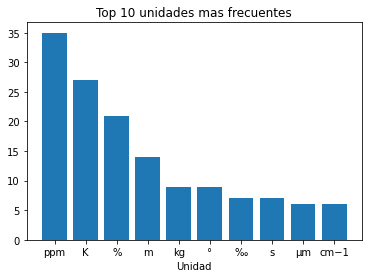

In [13]:
sorted_dict = dict(sorted(l_unidades.items(), key=lambda item: item[1],reverse=True))
y=list(sorted_dict.values())
x=list(sorted_dict.keys())
plt.bar(x[:10], y[:10])
plt.xlabel("Unidad")
plt.title("Top 10 unidades mas frecuentes")

In [14]:
quantity=pd.read_csv("data/trial/csv/NER_Quantity.csv")
quantity

,docId,Entity,Start,End,Tag
0,S0019103512002801-1927,about 0.1–0.2 s−1,152,169,Quantity
1,S0019103512002801-1927,5–10 s,212,218,Quantity
2,S0019103512004009-5019,30 nbar,310,317,Quantity
3,S0019103512004009-5019,1000 K,340,346,Quantity
4,S0019103512004009-5019,20 eV,680,685,Quantity
...,...,...,...,...,...
233,S0016236113008041-3171,13 kg,358,363,Quantity
234,S0016236113008041-3171,<1 ppm and,493,503,Quantity
235,S0016236113008041-3171,6 kg over 4.5 kg,626,642,Quantity
236,S0016236113008041-3171,from 6 kg to 13 kg,664,682,Quantity


In [15]:
import re
def unidades_cantidad(df,unidades):
    unidad_identificada=[]
    entidad=df["Entity"]
    encontrado=False
    df["Unidad"]=None

    for i,registro in enumerate(entidad):
        registro=registro.split()
        for token in registro:
            if max(list(map(lambda uni: fuzz.ratio(token,uni),unidades)))>88:
                df.iloc[i,-1]=token

            else:
                for u in unidades:
                    patron=re.search(rf"\d+{re.escape(u)}|{re.escape(u)}\.",token)
                    patron=  patron.group() if patron else ""#regresa el elemento que encontro, en su defecto una cadena vacia
                    if patron!="":
                        df.iloc[i,-1]=u
    return df

In [16]:
df=unidades_cantidad(quantity,list(l_unidades.keys()))

In [17]:
df.to_csv("data/trial/csv/NER_Quantity_unidades.csv",index=False)

In [18]:
unidades=pd.read_csv("data/trial/csv/NER_Quantity_unidades.csv")
unidades

,docId,Entity,Start,End,Tag,Unidad
0,S0019103512002801-1927,about 0.1–0.2 s−1,152,169,Quantity,s−1
1,S0019103512002801-1927,5–10 s,212,218,Quantity,s
2,S0019103512004009-5019,30 nbar,310,317,Quantity,nbar
3,S0019103512004009-5019,1000 K,340,346,Quantity,K
4,S0019103512004009-5019,20 eV,680,685,Quantity,eV
...,...,...,...,...,...,...
233,S0016236113008041-3171,13 kg,358,363,Quantity,kg
234,S0016236113008041-3171,<1 ppm and,493,503,Quantity,ppm
235,S0016236113008041-3171,6 kg over 4.5 kg,626,642,Quantity,kg
236,S0016236113008041-3171,from 6 kg to 13 kg,664,682,Quantity,kg


## Observamos cuales son las que no tienen unidad

In [19]:
unidades[unidades.Unidad.isnull()]

,docId,Entity,Start,End,Tag,Unidad
5,S0019103512004009-5019,0.45 W m−2,710,720,Quantity,NaN
7,S0019103513005058-1737,1 g cm−3,97,105,Quantity,NaN
34,S0012821X13002185-1231,30ε than,309,317,Quantity,NaN
36,S0012821X13002185-1231,385 (,759,764,Quantity,NaN
53,S0019103511004994-1511,two,605,608,Quantity,NaN
54,S0019103511004994-1511,five,713,717,Quantity,NaN
61,S0022459611006116-1195,from 5≤2θ/°≤80,170,184,Quantity,NaN
76,S0019103512004009-3825,from 0.1 to 1,350,363,Quantity,NaN
81,S0019103512004009-3825,1.,1000,1002,Quantity,NaN
99,S0019103512003533-3348,0.4,381,384,Quantity,NaN


## Modificadores

In [20]:
def get_sentences(df,text,tag):
    sentences=[]
    for i in df["annotSet"].unique():
        row=df[df["annotSet"]==i]
        max_index= row["endOffset"].max()
        min_index=row["startOffset"].min()
        sentences.append(text[min_index:max_index])
    for  sent in sentences:
      if tag in sent:
        return sent
    return None

#Escapar caracteres para evitar errores a la hora de usar expresiones regulares
def replace(entity):
    for sim in ["[","]","(",")","+"]:
        if sim in entity :
            entity=entity.replace(sim,f"\{sim}")
    return entity

In [21]:
def modifiers(data,text):
  train_data=[]
  for docId in data.keys():
    df=data[docId]
    for annot in df["annotSet"].unique():
      chunk=df[df["annotSet"]==annot]
      for i in chunk.index:
        dic=chunk.loc[i,"other"]
        if isinstance(dic,str):
          dic=json.loads(dic)
          if "mods" in dic.keys():
            mods=dic["mods"]
            if len(mods)>1:
              tag="-".join (mods)
            else:
              tag=mods[0]
            cantidad=replace(df.loc[i,"text"])
            sentence=get_sentences(df,text[docId],cantidad)
            if sentence:
              find=re.search(cantidad,sentence)
              inicio,fin=find.span()
              train_data.append((sentence,{"entities":[(inicio,fin,tag)]}))
  return train_data

mods=modifiers(data_train,train_text)

In [22]:
mods[0]

('follow-up screenings in 1997, 2003, and 2008',
 {'entities': [(24, 44, 'IsList')]})

In [ ]:
nlp = train_spacy(mods, 150)

In [ ]:
# Guardar modelo
nlp.to_disk("Modifiers")

In [40]:
unidades["Modificador"]=None
unidades

,docId,Entity,Start,End,Tag,Unidad,Modificador
0,S0019103512002801-1927,about 0.1–0.2 s−1,152,169,Quantity,s−1,None
1,S0019103512002801-1927,5–10 s,212,218,Quantity,s,None
2,S0019103512004009-5019,30 nbar,310,317,Quantity,nbar,None
3,S0019103512004009-5019,1000 K,340,346,Quantity,K,None
4,S0019103512004009-5019,20 eV,680,685,Quantity,eV,None
...,...,...,...,...,...,...,...
233,S0016236113008041-3171,13 kg,358,363,Quantity,kg,None
234,S0016236113008041-3171,<1 ppm and,493,503,Quantity,ppm,None
235,S0016236113008041-3171,6 kg over 4.5 kg,626,642,Quantity,kg,None
236,S0016236113008041-3171,from 6 kg to 13 kg,664,682,Quantity,kg,None


In [45]:
nlp=spacy.load("Modifiers")
for i in unidades.index:
  doc=nlp(unidades.loc[i,"Entity"])
  for ent in doc.ents:
    tag=ent.label_
    if "-" in tag:
      tag=",".join(tag.split("-"))
  unidades.loc[i,"Modificador"]=tag

In [46]:
unidades

,docId,Entity,Start,End,Tag,Unidad,Modificador
0,S0019103512002801-1927,about 0.1–0.2 s−1,152,169,Quantity,s−1,IsApproximate
1,S0019103512002801-1927,5–10 s,212,218,Quantity,s,IsRange
2,S0019103512004009-5019,30 nbar,310,317,Quantity,nbar,IsCount
3,S0019103512004009-5019,1000 K,340,346,Quantity,K,IsRange
4,S0019103512004009-5019,20 eV,680,685,Quantity,eV,IsCount
...,...,...,...,...,...,...,...
233,S0016236113008041-3171,13 kg,358,363,Quantity,kg,IsCount
234,S0016236113008041-3171,<1 ppm and,493,503,Quantity,ppm,IsRange
235,S0016236113008041-3171,6 kg over 4.5 kg,626,642,Quantity,kg,IsRange
236,S0016236113008041-3171,from 6 kg to 13 kg,664,682,Quantity,kg,IsRange


## Data Augmentation

In [ ]:
!pip install seqeval

In [ ]:
!pip install transformers

In [25]:
from tqdm import tqdm, trange
import transformers
from transformers import BertTokenizer, BertConfig,BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from transformers import pipeline

C:\ProgramData\Anaconda3\lib\site-packages\ray\tune\utils\util.py:7: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import defaultdict, deque, Mapping, Sequence


In [23]:
class TransformerAugmenter():
    """
    Use the pretrained masked language model to generate more
    labeled samples from one labeled sentence.
    """
    #topk=self.num_sample_tokens,
    def __init__(self):
        self.num_sample_tokens = 5
        self.fill_mask = pipeline(
            "fill-mask",
            model="distilroberta-base"
        )
    
    def generate(self, sentence, num_replace_tokens=3):
        """Return a list of n augmented sentences."""
              
        # run as often as tokens should be replaced
        augmented_sentence = sentence.copy()
        for i in range(num_replace_tokens):
            # join the text
            text = " ".join([w[0] for w in augmented_sentence])
            # pick a token
            replace_token = random.choice(augmented_sentence)
            # mask the picked token
            masked_text = text.replace(
                replace_token[0],
                f"{self.fill_mask.tokenizer.mask_token}",
                1            
            )
            # fill in the masked token with Bert
            res = self.fill_mask(masked_text)[random.choice(range(self.num_sample_tokens))]
            # create output samples list
            tmp_sentence, augmented_sentence = augmented_sentence.copy(), []
            for w in tmp_sentence:
                if w[0] == replace_token[0]:
                    augmented_sentence.append((res["token_str"].replace("Ġ", ""), w[1], w[2]))
                else:
                    augmented_sentence.append(w)
            text = " ".join([w[0] for w in augmented_sentence])
        return [sentence, augmented_sentence]

In [26]:
augmenter = TransformerAugmenter()

Downloading: 100%|██████████| 480/480 [00:00<00:00, 240kB/s]
Downloading: 100%|██████████| 331M/331M [00:55<00:00, 5.94MB/s]
Downloading: 100%|██████████| 899k/899k [00:00<00:00, 2.26MB/s]
Downloading: 100%|██████████| 456k/456k [00:00<00:00, 1.35MB/s]
Downloading: 100%|██████████| 1.36M/1.36M [00:00<00:00, 3.09MB/s]
Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
#Recibe una oracion y el numero de tokens que se quieren remplazar
def aumentar(text,n):
    data=[(word,0,0) for word in text.split()]
    original,sintetic=augmenter.generate(data, n)
    original=" ".join([word[0] for word in original])
    sintetic=" ".join([word[0] for word in sintetic])
    print(f"Original:\n{original}\n")
    print(f"Sintetico:\n{sintetic}")
    return {"original":original,"sintico":sintetic}

In [39]:
text= "The core consists of variably fissile claystone with interbedded fine to coarse grained sandstone layers interpreted as turbidites, with occasional mm-thick ash layers (Fig. 3). All samples in this study were taken from claystone horizons to avoid sampling substantial quantities of reworked material. The section of 22/10a-4 analysed in this study is from 2605 m to 2634 m (core depth), chosen because this part of the core is predominantly in claystone facies."
aumentar(text,20)

Original:
The core consists of variably fissile claystone with interbedded fine to coarse grained sandstone layers interpreted as turbidites, with occasional mm-thick ash layers (Fig. 3). All samples in this study were taken from claystone horizons to avoid sampling substantial quantities of reworked material. The section of 22/10a-4 analysed in this study is from 2605 m to 2634 m (core depth), chosen because this part of the core is predominantly in claystone facies.

Sintetico:
The core is from variably fissile claystone with interbedded fine ody coarse grained sandstone layers classified as limestone with occasional mm-thick ash layers (Fig. 3). All samples for this study were taken from claystone cores ody allow removing substantial contaminants from excess clay The section from 22/10a-4 analysed for this study is from 2605 12 ody 2634 12 (core depth), mainly because this segment from the core is reserved for claystone core


{'original': 'The core consists of variably fissile claystone with interbedded fine to coarse grained sandstone layers interpreted as turbidites, with occasional mm-thick ash layers (Fig. 3). All samples in this study were taken from claystone horizons to avoid sampling substantial quantities of reworked material. The section of 22/10a-4 analysed in this study is from 2605 m to 2634 m (core depth), chosen because this part of the core is predominantly in claystone facies.',
 'sintico': 'The core is from variably fissile claystone with interbedded fine ody coarse grained sandstone layers classified as limestone with occasional mm-thick ash layers (Fig. 3). All samples for this study were taken from claystone cores ody allow removing substantial contaminants from excess clay The section from 22/10a-4 analysed for this study is from 2605 12 ody 2634 12 (core depth), mainly because this segment from the core is reserved for claystone core'}